# Este projeto também está disponível localmente e no GITHUB

## Diretório do projeto e link do GITHUB

- 'C:/Users/miche/Desktop/CAPSTONE/insper0924'
- [Capstone_Outlier_Fcst](https://github.com/mconjaud/Capstone.git)



### Bibliotecas utilizadas


In [25]:
#Instalações necessárias
#!pip install sktime

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import linregress
from numpy.polynomial.polynomial import Polynomial
from prophet import Prophet
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    TBATS,
    StatsForecastAutoARIMA
)
from darts import TimeSeries
import sktime as sk
import os


### Codigo do Ativo Analisado




## Carregar o dataset e fazer conversões


In [49]:
# Carregar o dataset
CSAN23 = pd.read_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/CSAN23.csv')
df = CSAN23
# Converter a coluna de data para datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')
# Remover valores nulos e selecionar a variável de interesse
df_valid = df[['dataReferencia', 'taxaIndicativa']].dropna()

# Decomposição de série temporal

## 1 - Remoção da tendência

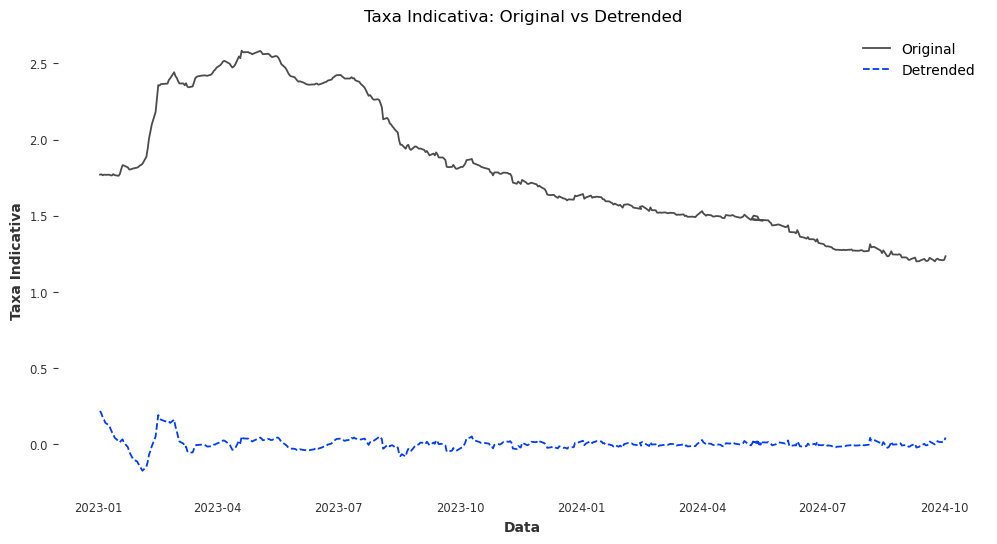

In [50]:
# Decomposição de série temporal e remoção da tendência
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')
df['taxaIndicativa_detrended'] = df['taxaIndicativa'] - result.trend

# Plotar a série temporal original e a série temporal sem a tendência
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_detrended'], label='Detrended', linestyle='--')
plt.title('Taxa Indicativa: Original vs Detrended')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

## 2- Remover a sazonalidade 

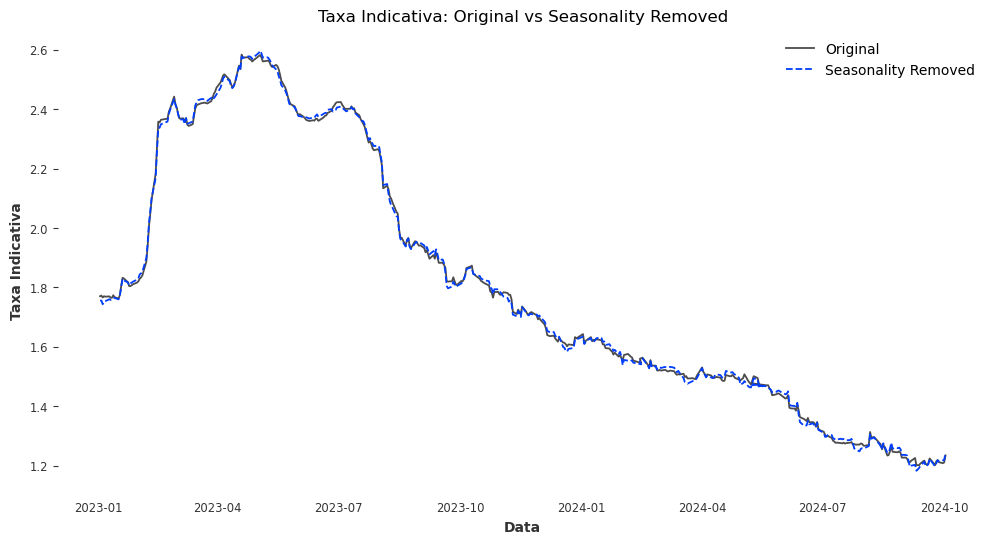

In [51]:
# Decomposição completa para a série original "taxaIndicativa"
result_full = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')

# Remover apenas a sazonalidade sem remover a tendência
df['taxaIndicativa_no_season'] = df['taxaIndicativa'] - result_full.seasonal

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_season'], label='Seasonality Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Seasonality Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


## 3- Remover a autocorrelação utilizando o ARIMA

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


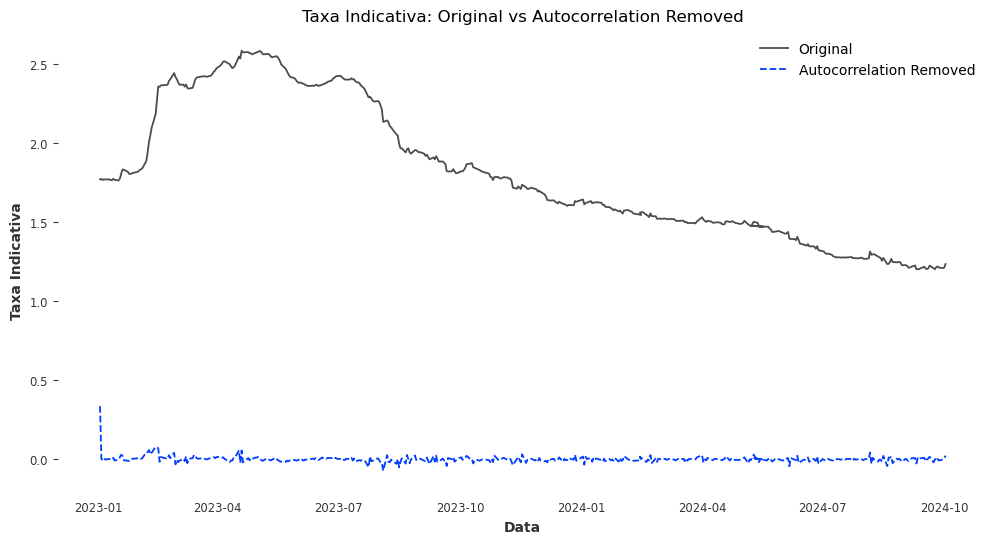

In [52]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar um modelo ARIMA para capturar autocorrelação
model = ARIMA(df['taxaIndicativa'].dropna(), order=(1, 0, 1))  # Modelo ARMA(1,1)
model_fit = model.fit()

# Obter os resíduos (valores sem autocorrelação)
df['taxaIndicativa_no_autocorr'] = model_fit.resid

# Plotar a série original e os resíduos sem autocorrelação
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_autocorr'], label='Autocorrelation Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Autocorrelation Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


In [53]:
# ============================================
# Teste ADF para verificar a estacionaridade
# ============================================
adf_result = adfuller(df_valid['taxaIndicativa'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

print("Teste Dickey-Fuller Aumentado (ADF) na série original:")
print(f"ADF Estatística: {adf_statistic}")
print(f"p-valor: {p_value}")
print("Valores críticos:", critical_values)
if p_value < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")


Teste Dickey-Fuller Aumentado (ADF) na série original:
ADF Estatística: -0.6024413336523654
p-valor: 0.8704294307120228
Valores críticos: {'1%': -3.44550760169756, '5%': -2.868222645936761, '10%': -2.5703296137102085}
A série não é estacionária.


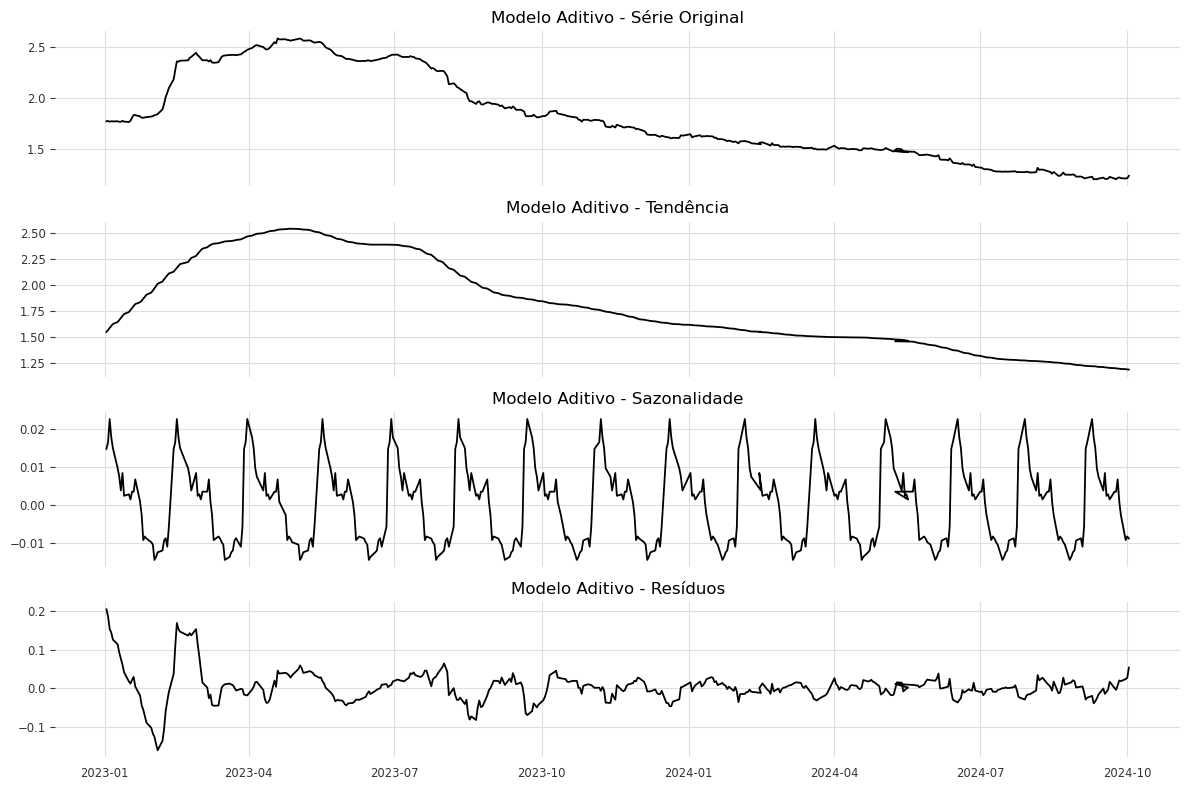

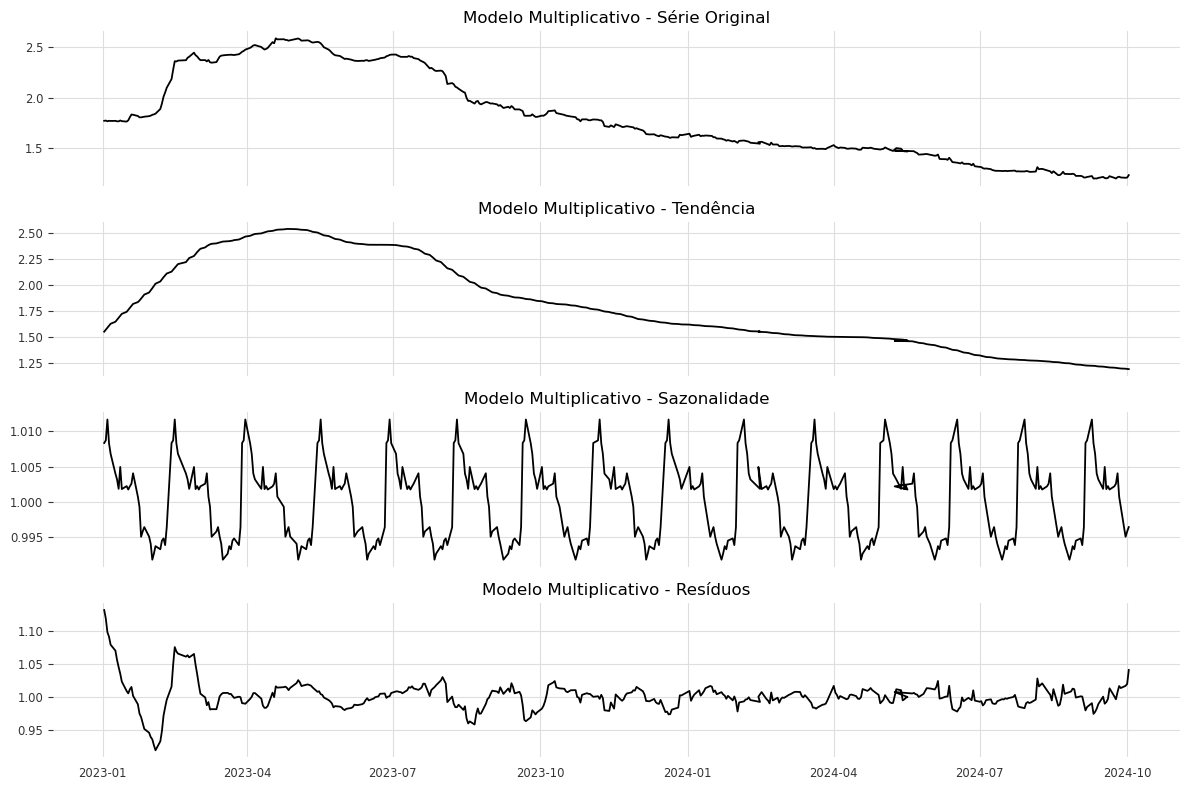

In [54]:
# ============================================
# Decomposição Aditiva e Multiplicativa
# ============================================
# Decomposição aditiva
result_add = seasonal_decompose(df_valid['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')

# Decomposição multiplicativa
result_mult = seasonal_decompose(df_valid['taxaIndicativa'], model='multiplicative', period=30, extrapolate_trend='freq')

# Plotar a decomposição aditiva
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Aditivo - Série Original')
axes[1].plot(df_valid['dataReferencia'], result_add.trend, label='Tendência')
axes[1].set_title('Modelo Aditivo - Tendência')
axes[2].plot(df_valid['dataReferencia'], result_add.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Aditivo - Sazonalidade')
axes[3].plot(df_valid['dataReferencia'], result_add.resid, label='Resíduos')
axes[3].set_title('Modelo Aditivo - Resíduos')
plt.tight_layout()
plt.show()

# Plotar a decomposição multiplicativa
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Multiplicativo - Série Original')
axes[1].plot(df_valid['dataReferencia'], result_mult.trend, label='Tendência')
axes[1].set_title('Modelo Multiplicativo - Tendência')
axes[2].plot(df_valid['dataReferencia'], result_mult.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Multiplicativo - Sazonalidade')
axes[3].plot(df_valid['dataReferencia'], result_mult.resid, label='Resíduos')
axes[3].set_title('Modelo Multiplicativo - Resíduos')
plt.tight_layout()
plt.show()


c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


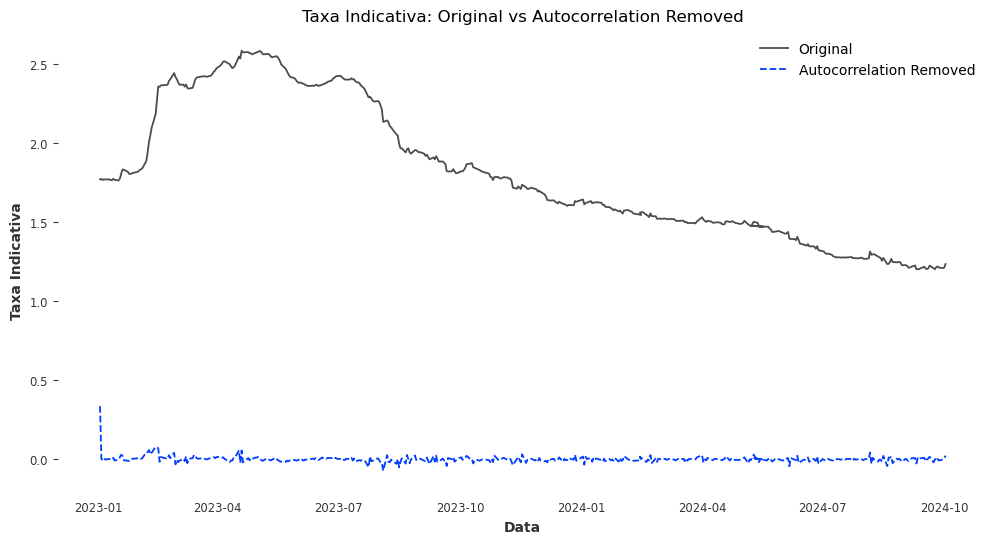

In [55]:
# ============================================
# Remoção da Autocorrelação com ARIMA
# ============================================
# Ajustar modelo ARIMA simples
model = ARIMA(df_valid['taxaIndicativa'], order=(1, 0, 1))
model_fit = model.fit()

# Resíduos sem autocorrelação
df_valid['taxaIndicativa_no_autocorr'] = model_fit.resid

# Plotar série original e resíduos sem autocorrelação
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa_no_autocorr'], label='Autocorrelation Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Autocorrelation Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


R² da tendência quadrática: 0.7759


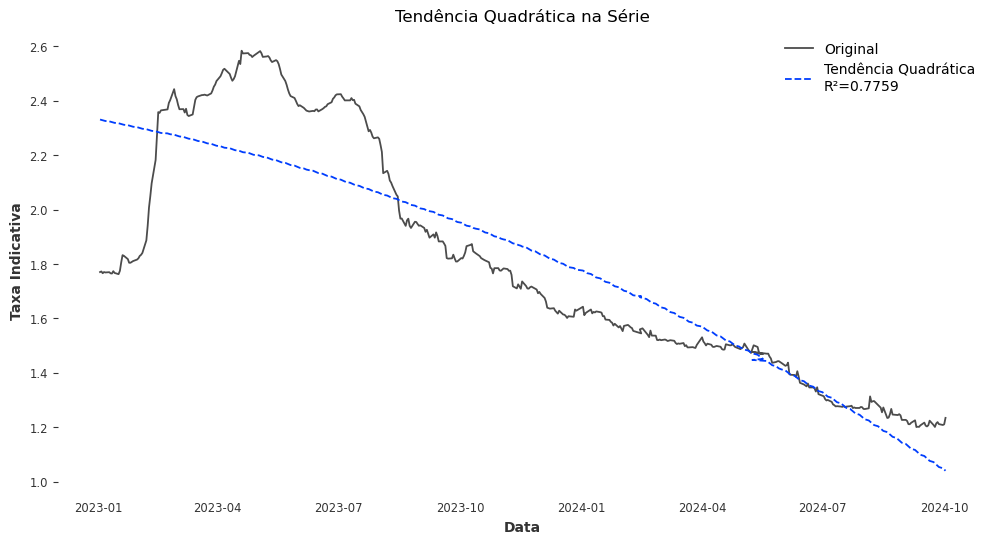

In [16]:
# ============================================
# Teste de Tendência Quadrática
# ============================================
# Ajustar modelo polinomial de grau 2
x = np.arange(len(df_valid))
y = df_valid['taxaIndicativa'].values
model_quadratic = Polynomial.fit(x, y, deg=2)
y_pred_quadratic = model_quadratic(x)

# R² para tendência quadrática
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred_quadratic)**2)
r_squared_quadratic = 1 - (ss_residual / ss_total)
print(f"R² da tendência quadrática: {r_squared_quadratic:.4f}")

# Plotar a tendência quadrática
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], y, label='Original', alpha=0.7)
plt.plot(df_valid['dataReferencia'], y_pred_quadratic, label=f'Tendência Quadrática\nR²={r_squared_quadratic:.4f}', linestyle='--')
plt.title('Tendência Quadrática na Série')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


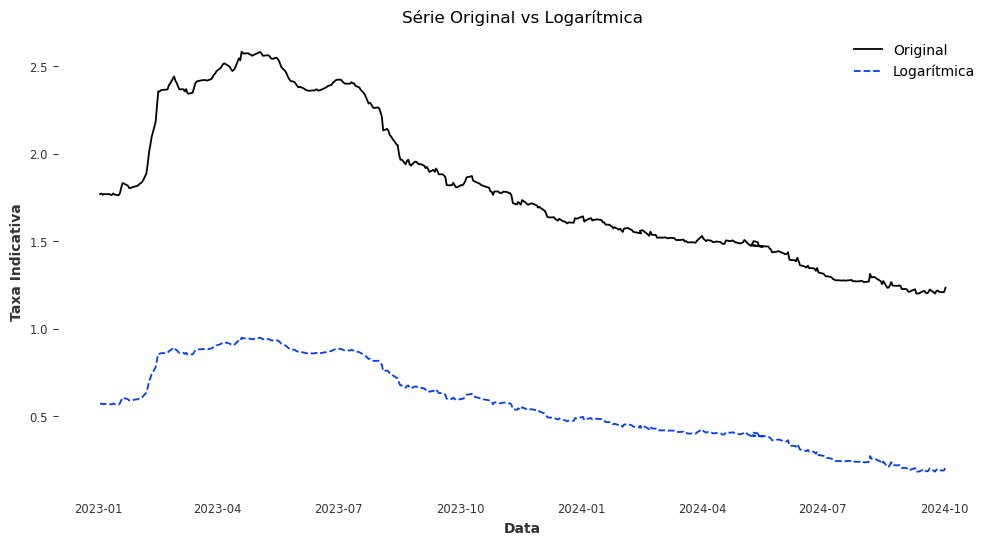

In [56]:

# ============================================
# Transformação Logarítmica
# ============================================
df_valid['taxaIndicativa_log'] = np.log(df_valid['taxaIndicativa'])
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Original')
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa_log'], label='Logarítmica', linestyle='--')
plt.title('Série Original vs Logarítmica')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


In [24]:

# ============================================
# Diferenciação para Tornar a Série Estacionária
# ============================================
# Aplicar diferenciação
df_valid['taxaIndicativa_diff'] = df_valid['taxaIndicativa'].diff().dropna()

# Teste ADF na série diferenciada
adf_result_diff = adfuller(df_valid['taxaIndicativa_diff'].dropna())
print("\nTeste ADF na Série Diferenciada:")
print(f"ADF Estatística: {adf_result_diff[0]}")
print(f"p-valor: {adf_result_diff[1]}")
print("Valores críticos:", adf_result_diff[4])
if adf_result_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")

# criar uma nova coluna com os valores da diferença
df['taxaIndicativa_diff'] = df['taxaIndicativa'].diff()


Teste ADF na Série Diferenciada:
ADF Estatística: -5.485085467671206
p-valor: 2.2393016971751245e-06
Valores críticos: {'1%': -3.44550760169756, '5%': -2.868222645936761, '10%': -2.5703296137102085}
A série diferenciada é estacionária.


In [36]:
df.columns

Index(['Unnamed: 0', 'id', 'dataReferencia', 'codigo', 'nome', 'repacVenc',
       'indice', 'correcao', 'taxaCompra', 'taxaVenda', 'taxaIndicativa',
       'desvioPadrao', 'intervaloMin', 'intervaloMax', 'pu', 'percPu',
       'duration', 'percReune', 'referenciaNTNB', 'spread_bid_ask', 'spread',
       'spread_2', 'taxaIndicativa_diff'],
      dtype='object')

In [ ]:
#Criar uma nova 

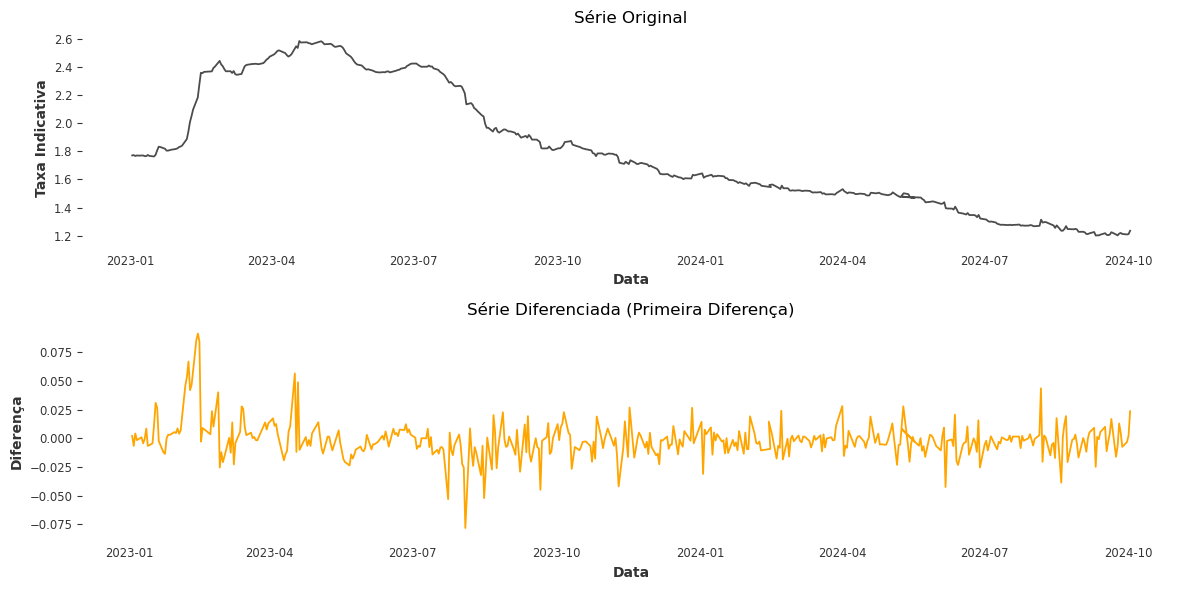

In [27]:
# Ajustar o Df para o data_valid
df_valid = df

# Plotar novamente com correção
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original', alpha=0.7)
plt.title('Série Original')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa_diff'], label='Série Diferenciada', color='orange')
plt.title('Série Diferenciada (Primeira Diferença)')
plt.xlabel('Data')
plt.ylabel('Diferença')
plt.grid()

plt.tight_layout()
plt.show()



### Realizar a ACF e PACF da variável taxaIndicativa_diff



KeyError: 'taxaIndicativa_diff'

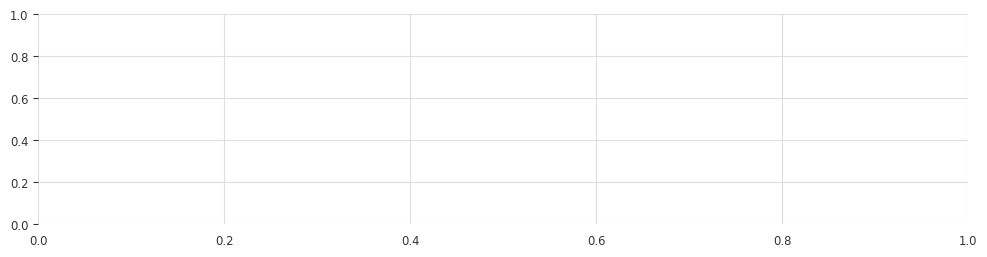

In [37]:
# Visualizar ACF e PACF para identificar os parâmetros (p, d, q)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_valid['taxaIndicativa_diff'].dropna(), lags=20, ax=plt.gca(), title='ACF da Série Diferenciada')
plt.subplot(2, 1, 2)
plot_pacf(df_valid['taxaIndicativa_diff'].dropna(), lags=20, ax=plt.gca(), title='PACF da Série Diferenciada')
plt.tight_layout()
plt.show()

## Realizar a previsao da série temporal utilizando o Auto ARIMA

In [29]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima


# Ajustar o modelo ARIMA automaticamente usando auto_arima na série diferenciada
stepwise_model = auto_arima(df_valid['taxaIndicativa_diff'].dropna(),
                            start_p=0, start_q=0,       # Valores iniciais de p e q
                            max_p=5, max_q=5,           # Valores máximos de p e q
                            d=0,                        # Série já diferenciada
                            seasonal=False,            # Sem sazonalidade
                            trace=True,                # Mostra os detalhes da busca
                            error_action='ignore',     # Ignora erros durante a busca
                            suppress_warnings=True,    # Suprime warnings
                            stepwise=True)             # Busca em modo stepwise

# Exibir o modelo selecionado
print(stepwise_model.summary())

# Fazer previsões para os próximos 7 períodos
n_periods = 7
forecast_diff, conf_int_diff = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)

# Reintegrar as previsões para retornar à escala original
forecast_original = np.cumsum(forecast_diff) + df_valid['taxaIndicativa'].iloc[-1]

# Criar datas futuras para a previsão
forecast_dates = pd.date_range(df_valid['dataReferencia'].iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original')
plt.plot(forecast_dates, forecast_original, label='Previsão ARIMA Automático', color='red', linestyle='--')
plt.fill_between(forecast_dates, 
                 np.cumsum(conf_int_diff[:, 0]) + df_valid['taxaIndicativa'].iloc[-1],
                 np.cumsum(conf_int_diff[:, 1]) + df_valid['taxaIndicativa'].iloc[-1],
                 color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.title('Previsão com Modelo ARIMA Automático na Série Diferenciada')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()



KeyError: 'taxaIndicativa_diff'

## Encontrado que o modelo que melhor se adapta é o SARIMAX (1,0,1)

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


                               SARIMAX Results                                
Dep. Variable:         taxaIndicativa   No. Observations:                  439
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1074.651
Date:                Sun, 15 Dec 2024   AIC                          -2143.302
Time:                        11:55:09   BIC                          -2131.048
Sample:                             0   HQIC                         -2138.467
                                - 439                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.000   2206.932      0.000       0.998       1.000
ma.L1          0.0994      0.031      3.175      0.001       0.038       0.161
sigma2         0.0004   1.55e-05     27.884      0.0

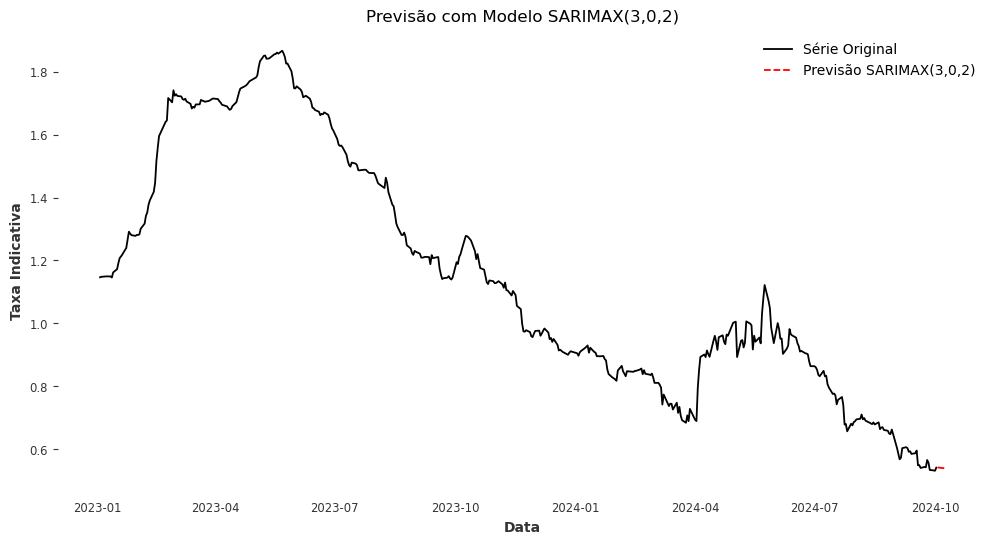

In [33]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar o modelo SARIMAX(5,0,0)
model_sarimax = SARIMAX(df_valid['taxaIndicativa'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model_sarimax.fit()

# Exibir o resumo do modelo
print(model_fit.summary())

# Fazer previsões para os próximos 7 períodos
n_periods = 7
forecast = model_fit.forecast(steps=n_periods)

# Criar datas futuras para a previsão
forecast_dates = pd.date_range(df_valid['dataReferencia'].iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar a série original e as previsões
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original')
plt.plot(forecast_dates, forecast, label='Previsão SARIMAX(3,0,2)', color='red', linestyle='--')
plt.title('Previsão com Modelo SARIMAX(3,0,2)')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


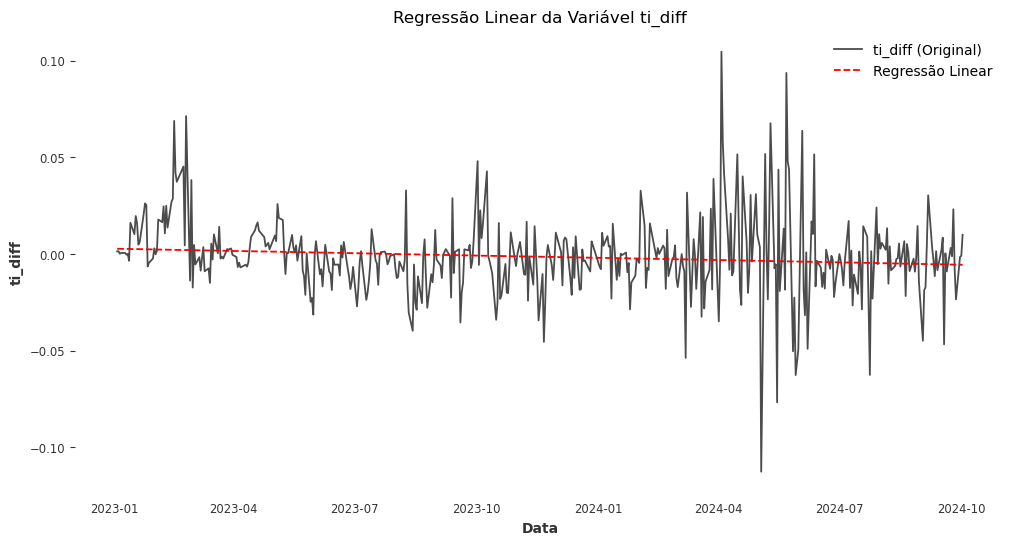

(-1.8977141527926316e-05, 0.002780367570925658, 0.01343689293887651)

In [34]:
# Recarregar bibliotecas e dados após reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Remover valores nulos da variável ti_diff
df_valid = df_valid.dropna(subset=['ti_diff'])

# Preparar dados para regressão
x = np.arange(len(df_valid)).reshape(-1, 1)  # Variável independente: tempo
y = df_valid['ti_diff'].values.reshape(-1, 1)  # Variável dependente: ti_diff

# Ajustar o modelo de regressão linear
model = LinearRegression()
model.fit(x, y)

# Prever os valores ajustados
y_pred = model.predict(x)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_valid['dataReferencia'], y, label='ti_diff (Original)', alpha=0.7)
plt.plot(df_valid['dataReferencia'], y_pred, label='Regressão Linear', color='red', linestyle='--')
plt.title('Regressão Linear da Variável ti_diff')
plt.xlabel('Data')
plt.ylabel('ti_diff')
plt.legend()
plt.grid()
plt.show()

# Coeficientes da regressão
slope = model.coef_[0][0]
intercept = model.intercept_[0]
r_squared = model.score(x, y)

slope, intercept, r_squared


In [32]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt


# Aplicar auto_arima para minimizar o AIC
auto_model = auto_arima(
    df['ti_diff'].dropna(),
    start_p=0, start_q=0,     
    max_p=5, max_q=5,         
    d=0,                      
    seasonal=False,           
    trace=True,               
    error_action='ignore',    
    suppress_warnings=True,   
    stepwise=True             
)

# Exibir o resumo do modelo e o melhor AIC encontrado
print(auto_model.summary())
print(f"Melhor AIC: {auto_model.aic()}")

# Previsão futura
n_periods = 7
forecast, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Criar datas para a previsão
forecast_dates = pd.date_range(df['dataReferencia'].dropna().iloc[-1], periods=n_periods + 1, freq='D')[1:]

# Plotar previsões
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['ti_diff'], label='ti_diff (Original)')
plt.plot(forecast_dates, forecast, label='Previsão Auto-ARIMA', color='red', linestyle='--')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.title('Previsão com Auto-ARIMA para Minimização de AIC')
plt.xlabel('Data')
plt.ylabel('ti_diff')
plt.legend()
plt.grid()
plt.show()


KeyError: 'ti_diff'

## Fazendo o Split Mensal

In [48]:
# Criar uma nova coluna 'AnoMes' para agrupar por ano e mês
#df['AnoMes'] = df['dataReferencia'].dt.to_period('M')

# Criar um diretório para salvar as séries mensais
#output_dir = "series_mensais"
#os.makedirs(output_dir, exist_ok=True)

# Iterar pelos meses únicos e salvar cada subconjunto em um arquivo CSV
#for period, group in df.groupby('AnoMes'):
#    output_file = os.path.join(output_dir, f"ALGA_MBM_{period}.csv")
#    group.to_csv(output_file, index=False)
#    print(f"Série mensal salva: {output_file}")


Série mensal salva: series_mensais\ALGA_MBM_2023-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-06.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-07.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-08.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-09.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-10.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-11.csv
Série mensal salva: series_mensais\ALGA_MBM_2023-12.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-01.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-02.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-03.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-04.csv
Série mensal salva: series_mensais\ALGA_MBM_2024-05.csv
Série mensal salva: series_mensais\ALGA_MBM_2024

## Fazendo o Split Trimestral

In [40]:
# Criar uma nova coluna 'AnoTrimestre' para agrupar por trimestre
df['AnoTrimestre'] = df['dataReferencia'].dt.to_period('Q')  # Q = Trimestre

# Criar um diretório para salvar as séries trimestrais
output_dir = "series_trimestrais"
#os.makedirs(output_dir, exist_ok=True)

# Iterar pelos trimestres únicos e salvar cada subconjunto em um arquivo CSV
for period, group in df.groupby('AnoTrimestre'):
    output_file = os.path.join(output_dir, f"CSAN23{period}.csv")
    group.to_csv(output_file, index=False)
    print(f"Série trimestral salva: {output_file}")


Série trimestral salva: series_trimestrais\CSAN232023Q1.csv
Série trimestral salva: series_trimestrais\CSAN232023Q2.csv
Série trimestral salva: series_trimestrais\CSAN232023Q3.csv
Série trimestral salva: series_trimestrais\CSAN232023Q4.csv
Série trimestral salva: series_trimestrais\CSAN232024Q1.csv
Série trimestral salva: series_trimestrais\CSAN232024Q2.csv
Série trimestral salva: series_trimestrais\CSAN232024Q3.csv
Série trimestral salva: series_trimestrais\CSAN232024Q4.csv


In [41]:
#contar quantos registro tem no arquivo series_trimestrais\ALGA_MBM_2024Q4.csv
# Carregar o dataset
file_path = "series_trimestrais\CSAN232024Q3.csv"
df = pd.read_csv(file_path)
print(f"Total de registros no arquivo {file_path}: {df.shape[0]}")

Total de registros no arquivo series_trimestrais\CSAN232024Q3.csv: 66


### Previsao dos ultimos 7 dias baseados em 3 meses

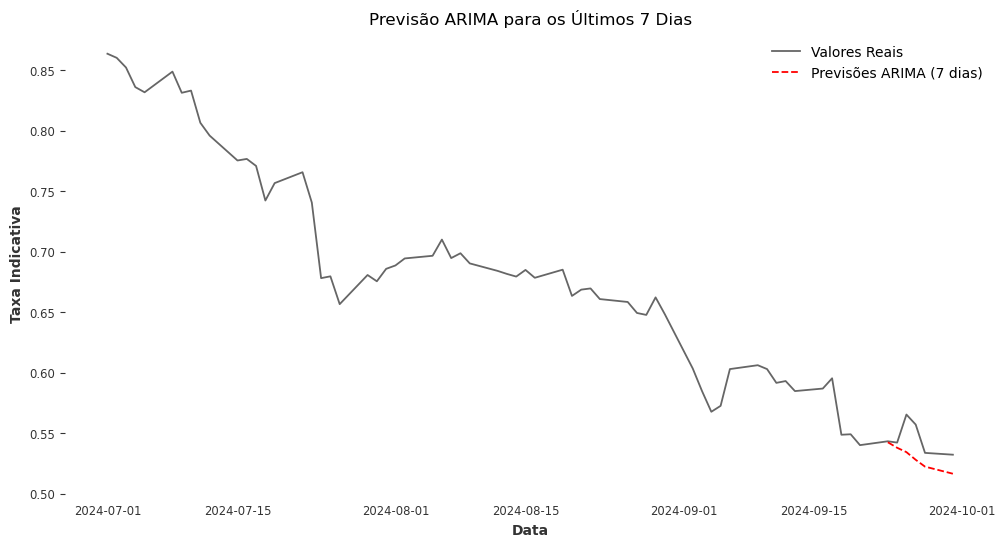

         Data  Valores Reais  Previsões
59 2024-09-23         0.5432   0.542364
60 2024-09-24         0.5421   0.537830
61 2024-09-25         0.5653   0.534224
62 2024-09-26         0.5570   0.527870
63 2024-09-27         0.5336   0.522230
64 2024-09-30         0.5321   0.516363


In [42]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Converter a coluna de datas para o formato datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Ordenar por data e remover valores nulos
df = df.sort_values(by='dataReferencia').dropna(subset=['taxaIndicativa'])

# Criar a variável diferenciada
df['ti_diff'] = df['taxaIndicativa'].diff().dropna()

# Filtrar apenas a série diferenciada (ignorar o primeiro valor NaN da diferenciação)
df_diff = df.dropna(subset=['ti_diff']).reset_index(drop=True)

# Dividir os dados: treino (22 primeiros dias) e teste (7 dias seguintes)
train = df_diff.iloc[:59]
test = df_diff.iloc[59:66]

# Treinar o modelo ARIMA
model = ARIMA(train['ti_diff'], order=(3, 0, 2))  # Ordem ARIMA pode ser ajustada
model_fit = model.fit()

# Fazer previsões para os próximos 7 dias
forecast = model_fit.forecast(steps=len(test))

# Reintegrar a série diferenciada para compará-la com os valores reais
# Somar os valores previstos cumulativamente ao último valor da série original de treino
forecast_reintegrated = np.cumsum(forecast) + train['taxaIndicativa'].iloc[-1]

# Preparar os valores reais da série original
real_values = test['taxaIndicativa']

# Criar datas para as previsões
forecast_dates = test['dataReferencia']

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Valores Reais', alpha=0.6)
plt.plot(forecast_dates, forecast_reintegrated, label='Previsões ARIMA (7 dias)', color='red', linestyle='--')
plt.title('Previsão ARIMA para os Últimos 7 Dias')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

# Exibir previsões e valores reais
forecast_results = pd.DataFrame({
    'Data': forecast_dates,
    'Valores Reais': real_values.values,
    'Previsões': forecast_reintegrated.values
})
print(forecast_results)


### Aplicando a biblioteca SKTIME no modelo de previsão para os proximos 3 dias

In [ ]:
# Carregar o dataset
file_path = 'series_trimestrais\CSAN232024Q3.csv'  # Caminho correto do arquivo
df = pd.read_csv(file_path)

# Converter a coluna de datas para o formato datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Ordenar por data e remover valores nulos
df = df.sort_values(by='dataReferencia').dropna(subset=['taxaIndicativa'])

# Criar a variável diferenciada
df['taxaIndicativa_diff'] = df['taxaIndicativa'].diff().dropna()

# Remover valores NaN criados pela diferenciação
df_diff = df.dropna(subset=['taxaIndicativa_diff']).reset_index(drop=True)

# Dividir os dados: treino (59 primeiros dias) e teste (7 dias seguintes)
train = df_diff.iloc[:28]
test = df_diff.iloc[28:31]

# Preparar as séries para o sktime
y_train = train['taxaIndicativa_diff']
y_test = test['taxaIndicativa_diff']

# Criar e treinar o modelo AutoARIMA do sktime
forecaster = AutoARIMA(sp=1, suppress_warnings=True)  # sp=1: Sem sazonalidade explícita
forecaster.fit(y_train)

# Fazer previsões no horizonte de 7 dias
fh = np.arange(1, len(y_test) + 1)  # Janela de previsão (1 a 7)
y_pred = forecaster.predict(fh=fh)

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Treino')
plt.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='blue')
plt.plot(y_test.index, y_pred, label='Previsão (AutoARIMA)', color='red', linestyle='--')
plt.title('Previsão com AutoARIMA (sktime) - taxaIndicativa_diff')
plt.xlabel('Índice')
plt.ylabel('taxaIndicativa_diff')
plt.legend()
plt.grid()
plt.show()

# Avaliar a previsão
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Erro MAPE (Mean Absolute Percentage Error): {mape:.2%}")


ValueError: Train `series` must be a single `TimeSeries`.


ValueError: Train `series` must be a single `TimeSeries`.

### Rodar uma analise de correlacao entre as variaveis dentro do titulo ALGA28

# Professor Michel
#### Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

+ Remover a tendencia
+ Remover a sazonalidade
+ Remover a autocorrelacao
+ colocarr a base logaritmica (Se tiver uma tendencia exponencial)
+ Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
+ Dado essa serie aplique Dick Fuller, e trace a media da curva.
+ Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#### Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
### aplicar a regressao classica na serie mais estacionaria.

# Heitor
+ Dentro da série diferenciada. Realizar uma distribuição num histograma de grequencia para verificar se a distribuição é normal.
+ Fazer  o previsto contra o realizado pra diversas datas.
+ Varios gráficos de 22 dias
+ Retirar os dados antes de 2023


## Professor Michel

- Trocar ativos 3 ativos distintos
- Regressao linear com os labels
- Regressao linera multivariada
- Serie temporal multivariada


In [44]:
#Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

#Remover a tendencia
#Remover a sazonalidade
#Remover a autocorrelacao
#colocarr a base logaritmica (Se tiver uma tendencia exponencial)
#Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
#Dado essa serie aplique Dick Fuller, e trace a media da curva.
#Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
# aplicar a regressao classica na serie mais estacionaria.

In [45]:
#remover a tendencia da variavel temporal taxaIndicativa
